In [1]:
import sys, itertools, re, sqlite3, math, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Normalization
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.display import display, Markdown
from PIL import Image

rcParams["figure.figsize"] = (18,8)
rcParams["axes.spines.top"] = False
rcParams["axes.spines.right"] = False
current_path = os.getcwd()
sys.path.append(current_path)

# enable to get always the same result model
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

NUM_OF_CATEGORIES = 4

current_path = os.getcwd()
sys.path.append(current_path)

con = sqlite3.connect(f"{current_path}/tmp/test.db3")
cur = con.cursor()

feature_column = "k_rechtsvorm,k_sbi1,k_sbi2,k_sbi3,j_account,j_subcat,j_bedrag,c_investeringsverw,c_beursontwikkeling,m_M,m_UM,m_TA,r_bestaan,r_voorkomen,r_volledigheid,r_nauwkeurigheid,r_waardering,r_afgrenzing,r_classificatie,r_presentatie,r_rechten_en_verplichtingen"
feature_names = feature_column.split(',')
cur.execute(f"SELECT {feature_column},o_conclusie FROM inputdata WHERE j_subcat is not NULL ORDER BY o_conclusie")

parameters = [[float(item or 0) for item in row] for row in cur.fetchall()]
expected = [int(row[-1]) for row in parameters]
parameters = [row[:-1] for row in parameters]

# scale
scaler = StandardScaler()
parameters = scaler.fit_transform(parameters)

# normalize
normalizer = Normalizer()
parameters = normalizer.fit_transform(parameters)

print("Outcome diversity: ", expected.count(0),expected.count(1),expected.count(2),expected.count(3))

# oversample
over = RandomOverSampler()
parameters, expected = over.fit_resample(parameters, expected)

print("Outcome oversampling: ", expected.count(0),expected.count(1),expected.count(2),expected.count(3))

# Generate Training and Validation Sets
X_temp, X_train, y_temp, y_train = train_test_split(parameters, expected, test_size=0.75, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0)

y_train_list = y_train
y_valid_list = y_valid
y_test_list = y_test

X_train, X_temp, y_train, y_temp = np.array(X_train), np.array(X_temp), np.array(y_train), np.array(y_temp)
X_valid, X_test, y_valid, y_test = np.array(X_valid), np.array(X_test), np.array(y_valid), np.array(y_test)


print("Train date per outcome:", y_train_list.count(0),y_train_list.count(1),y_train_list.count(2),y_train_list.count(3))
print("Valid date per outcome:",y_valid_list.count(0),y_valid_list.count(1),y_valid_list.count(2),y_valid_list.count(3))
print("Test date per outcome:",y_test_list.count(0),y_test_list.count(1),y_test_list.count(2),y_test_list.count(3))


print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

from keras import utils
y_nosparse_train = utils.to_categorical(y_train, NUM_OF_CATEGORIES)
y_nosparse_valid = utils.to_categorical(y_valid, NUM_OF_CATEGORIES)
y_nosparse_test = utils.to_categorical(y_test, NUM_OF_CATEGORIES)

Outcome diversity:  1032 3524 1296 1036
Outcome oversampling:  3524 3524 3524 3524
Train date per outcome: 2652 2632 2648 2640
Valid date per outcome: 436 424 432 468
Test date per outcome: 436 468 444 416
(10572, 21) (10572,)
(1760, 21) (1760,)
(1764, 21) (1764,)


In [2]:
EPOCHS = 1000
model = Sequential()
# input layer
model.add(Input(shape=(X_train.shape[1],)))
# hidden layers
model.add(Dense(units=64, activation='relu',activity_regularizer=tf.keras.regularizers.l1(0.001)))
model.add(Dropout(0.15))
model.add(Dense(units=32, activation='relu',activity_regularizer=tf.keras.regularizers.l1(0.001)))
model.add(Dropout(0.15))
# output layer
model.add(Dense(units=NUM_OF_CATEGORIES, activation='softmax'))
# compile and fit
model.compile(loss=tf.losses.CategoricalCrossentropy(), 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              metrics=[
                  tf.keras.metrics.CategoricalAccuracy(name="accuracy"), 
                  tf.keras.metrics.Precision(name="precision"), 
                  tf.keras.metrics.Recall(name="recall")
              ])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100)
]

h = model.fit(X_train, y_nosparse_train, epochs=EPOCHS, batch_size=64, validation_data=(X_valid, y_nosparse_valid),callbacks=callbacks)
e = model.evaluate(X_test, y_nosparse_test, verbose=2)

Epoch 1/1000


I0000 00:00:1715343254.707121  339246 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 [==============================] - 1s 5ms/step - loss: 1.3868 - accuracy: 0.2932 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3595 - val_accuracy: 0.4136 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/1000
42/42 [==============================] - 0s 2ms/step - loss: 1.3426 - accuracy: 0.3874 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3171 - val_accuracy: 0.4409 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/1000
42/42 [==============================] - 0s 1ms/step - loss: 1.3036 - accuracy: 0.4328 - precision: 0.8000 - recall: 0.0030 - val_loss: 1.2736 - val_accuracy: 0.4932 - val_precision: 0.5000 - val_recall: 0.0023
Epoch 4/1000
42/42 [==============================] - 0s 2ms/step - loss: 1.2583 - accuracy: 0.4642 - precision: 0.8033 - recall: 0.0185 - val_loss: 1.2281 - val_accuracy: 0.5500 - val_precision: 0.5455 - val_recall: 0.0136
Epoch 5/1000
42/42 [==============================] - 0s 2ms/step - loss: 1.2276 - ac

<h2>Multi-layer perceptron</h2>

Loss: 0.44
Accuracy: 85%
Precision: 0.87
Recall: 0.84


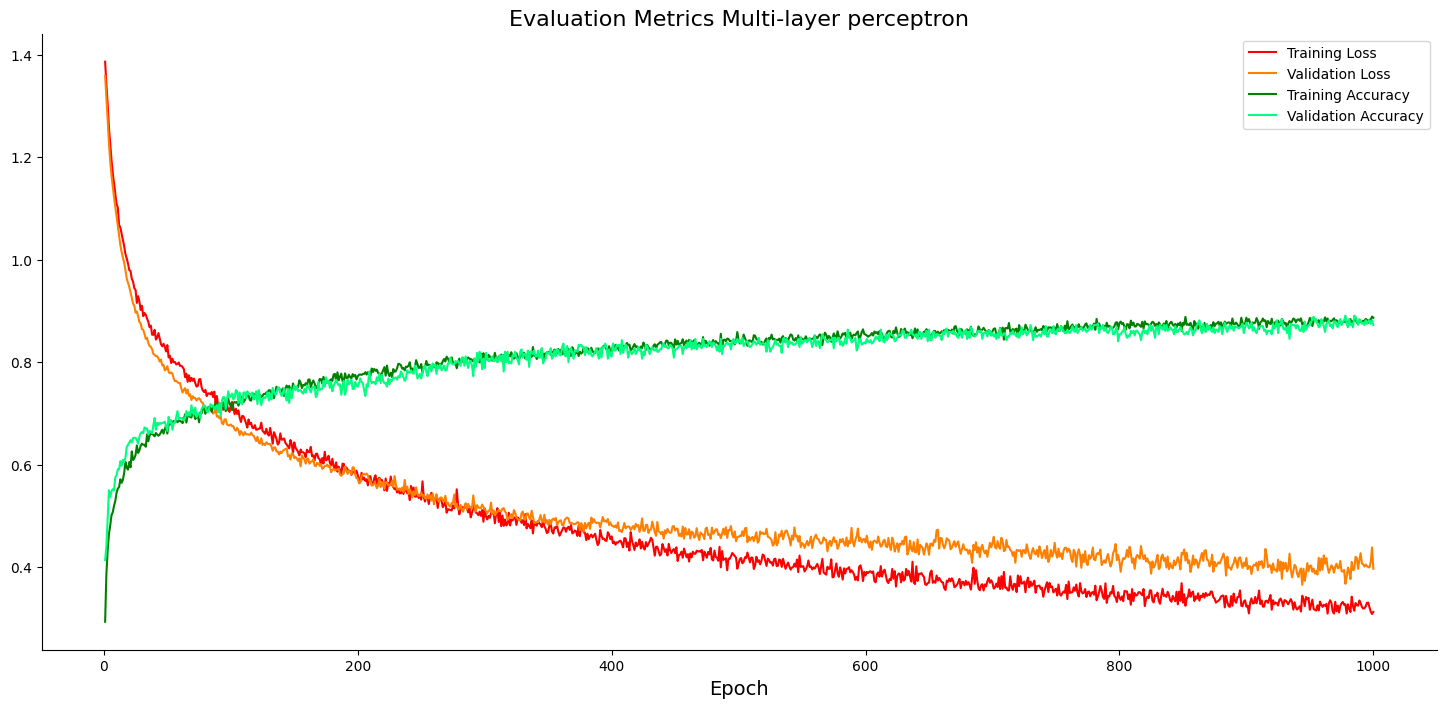

In [3]:
name = "Multi-layer perceptron"
display(Markdown(f'<h2>{name}</h2>'))
print(f'Loss: {e[0]:.2f}')
print(f'Accuracy: {int(e[1] * 100)}%')
print(f'Precision: {e[2]:.2f}')
print(f'Recall: {e[3]:.2f}')

plt.figure(0)
range_epochs = np.arange(1, len(h.history['loss'])+1)
plt.plot(range_epochs, h.history['loss'], label='Training Loss',color='red')
plt.plot(range_epochs, h.history['val_loss'], label='Validation Loss',color='#ff8000')
plt.plot(range_epochs, h.history['accuracy'], label='Training Accuracy',color='green')
plt.plot(range_epochs, h.history['val_accuracy'], label='Validation Accuracy',color='#00ff80')
#plt.plot(range_epochs, h.history['precision'], label='Precision',color='blue')
#plt.plot(range_epochs, h.history['recall'], label='Recall',color='orange')
plt.title(f"Evaluation Metrics {name}", size=16)
plt.xlabel("Epoch", size=14)
plt.legend()
plt.show()

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


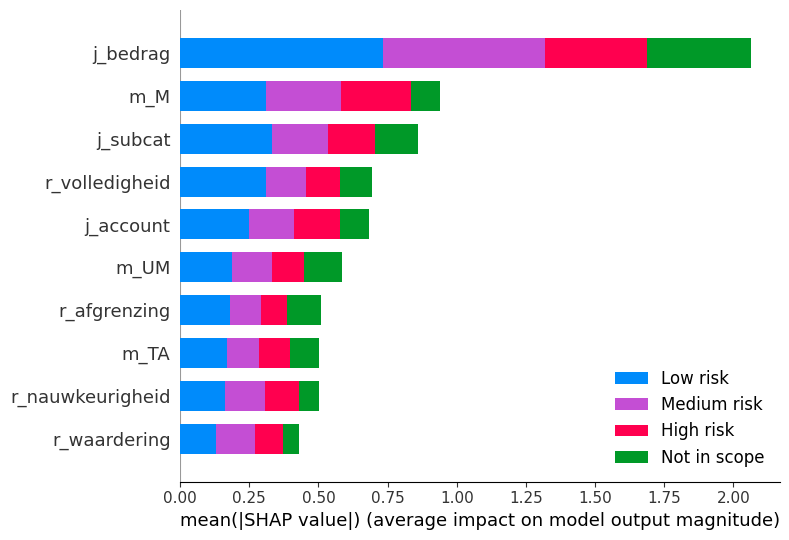

In [4]:
import shap
shap.initjs()
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_valid)
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=feature_names,max_display=10, class_names=["Not in scope","Low risk","Medium risk","High risk"])

In [5]:
def save():
    save_file = os.path.join(current_path,"tmp","save.db3")
    if os.path.exists(save_file): os.remove(save_file)
    conn = sqlite3.connect(save_file)
    curr = conn.cursor()
    columns = []
    for i, p in enumerate(X_train[0]): columns.append(f"{feature_names[i]} real")
    columns.append("result int")
    columns.append("set_type text")
    curr.execute(f"CREATE TABLE IF NOT EXISTS DataSet ({','.join(columns)})")
    save_set = []
    for i, p in enumerate(X_train):
        save_set.append(list(p) + [int(y_train[i])] + ["training"])
    
    for i, p in enumerate(X_valid):
        save_set.append(list(p) + [int(y_valid[i])] + ["valid"])
    
    for i, p in enumerate(X_test):
        save_set.append(list(p) + [int(y_test[i])] + ["test"])
    q = ["?" for c in columns]
    curr.executemany(f"INSERT INTO DataSet VALUES ({','.join(q)})", save_set)
    conn.commit()
    conn.close()
#save()